<h1>  Tasas de interés de vivienda </h1>

In [1]:
import os
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap
from collections import Counter
from datetime import datetime
from dotenv import load_dotenv

In [2]:
# Cargue variables de entorno. 
load_dotenv()

ruta_archivo = os.getenv('RUTA_ARCHIVO')

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo, delimiter=";", on_bad_lines="skip")

<p> Columnas del dataframe </p>

In [3]:
df.columns

Index(['Tipo_Entidad', 'Nombre_Tipo_Entidad', 'Codigo_Entidad',
       'Nombre_Entidad', 'Fecha_Corte', 'Tipo_de_persona', 'Sexo',
       'Tamaño_de_empresa', 'Tipo_de_crédito', 'Tipo_de_garantía',
       'Producto de crédito', 'Plazo de crédito',
       'Tasa_efectiva_promedio_ponderada', 'margen_adicional',
       'Montos_desembolsados', 'Numero_de_creditos_desembolsados',
       'Grupo_Etnico', 'Antiguedad_de_la_empresa', 'Tipo_de_Tasa',
       'Rango_monto_desembolsado', 'Clase_deudor', 'Codigo_CIIU',
       'Codigo_Municipio'],
      dtype='object')

In [4]:
pd.options.display.max_columns = 100 # --> Mostrar todas las columnas.
df.head(3)

,Tipo_Entidad,Nombre_Tipo_Entidad,Codigo_Entidad,Nombre_Entidad,Fecha_Corte,Tipo_de_persona,Sexo,Tamaño_de_empresa,Tipo_de_crédito,Tipo_de_garantía,Producto de crédito,Plazo de crédito,Tasa_efectiva_promedio_ponderada,margen_adicional,Montos_desembolsados,Numero_de_creditos_desembolsados,Grupo_Etnico,Antiguedad_de_la_empresa,Tipo_de_Tasa,Rango_monto_desembolsado,Clase_deudor,Codigo_CIIU,Codigo_Municipio
0,1,BC-ESTABLECIMIENTO BANCARIO,1,Banco de Bogotá,19/01/2024,Natural,Femenino,No aplica,Vivienda,Garantia idónea o no idónea,Adquisición de vivienda vis (colocación en pesos),A más de 20 años,15.53,0,"77,851,946",1,Sin información (1),No aplica(1),FS,Hasta 135 SMLMV,Deudor de la entidad,10,66682
1,1,BC-ESTABLECIMIENTO BANCARIO,13,BBVA Colombia,19/01/2024,Natural,Masculino,No aplica,Vivienda,Garantia idónea o no idónea,Adquisición de vivienda no vis (colocación en ...,Más de 7 años y hasta 15 años,17.81,0,"239,504,333",1,Sin información (1),No aplica(1),FS,Mayor a 135 SMLMV y menor o igual a 235 SMLMV,Deudor de la entidad,10,25126
2,1,BC-ESTABLECIMIENTO BANCARIO,7,Bancolombia,19/01/2024,Natural,Masculino,No aplica,Vivienda,Garantia idónea o no idónea,Adquisición de vivienda no vis (colocación en ...,Más de 15 años y hasta 20 años,17.45,0,"174,916,887",1,Sin información (1),No aplica(1),FS,Hasta 135 SMLMV,Deudor nuevo en la entidad,10,5001


In [5]:
# Descripción de las variables de estudio. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86979 entries, 0 to 86978
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Tipo_Entidad                      86979 non-null  int64  
 1   Nombre_Tipo_Entidad               86979 non-null  object 
 2   Codigo_Entidad                    86979 non-null  int64  
 3   Nombre_Entidad                    86979 non-null  object 
 4   Fecha_Corte                       86979 non-null  object 
 5   Tipo_de_persona                   86979 non-null  object 
 6   Sexo                              86979 non-null  object 
 7   Tamaño_de_empresa                 86979 non-null  object 
 8   Tipo_de_crédito                   86979 non-null  object 
 9   Tipo_de_garantía                  86979 non-null  object 
 10  Producto de crédito               86979 non-null  object 
 11  Plazo de crédito                  86979 non-null  object 
 12  Tasa

<h3> Data Wrangling </h3>

<p> Se procede a imputar datos en la columna Plazo de crédito, asignando un valor numerico entero, dados los rangos suministrados en el dataset original </p>

In [6]:
def calcular_anios_aproximados(plazo):
    """
    Calcula el número aproximado de años de un plazo de crédito.
    Args:
        plazo: El plazo de crédito en formato texto.
    Returns:
        int: El número aproximado de años en formato entero.
    """
    if plazo == "A más de 20 años":
        return 30
    elif plazo == "Más de 7 años y hasta 15 años":
        return 15
    elif plazo == "Más de 15 años y hasta 20 años":
        return 20
    elif plazo == "Más de 5 años y hasta 7 años":
        return 7
    elif plazo == "Vivienda hasta 5 años":
        return 5
    else:
        return None 

In [7]:
# Aplicar la función.
df['cant_anios_aprox'] = df['Plazo de crédito'].apply(calcular_anios_aproximados)

<p> Transformación de columna "Fecha_Corte" a tipo DATE.</p>

In [8]:
# Suponiendo que tienes un DataFrame llamado 'df' con la columna 'Fecha_Corte'
df['Fecha_Corte'] = pd.to_datetime(df['Fecha_Corte'], format='%d/%m/%Y')

In [9]:
# Limpia la columna 'Montos_desembolsados' eliminando caracteres no numéricos
df['Montos_desembolsados'] = df['Montos_desembolsados'].replace({r'[^\d.]': ''}, regex=True)

# Convierte la columna 'Montos_desembolsados' a tipo numérico
df['Montos_desembolsados'] = pd.to_numeric(df['Montos_desembolsados'], errors='coerce')

<h3> Feature Selection - Selección de caracteristicas. </h3>
<p> Se determina reducir el tamaño del dataframe, eliminando las variables que no agregan valor las cuales son:</p>
<li>Tamaño_de_empresa </li>
<li> Tipo_de_crédito</li>
<li> margen_adicional</li>
<li> Antiguedad_de_la_empresa</li>

In [10]:
columnas_a_eliminar = ['Tamaño_de_empresa', 'Tipo_de_crédito', 'margen_adicional', 'Antiguedad_de_la_empresa']
df.drop(columnas_a_eliminar, axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86979 entries, 0 to 86978
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Tipo_Entidad                      86979 non-null  int64         
 1   Nombre_Tipo_Entidad               86979 non-null  object        
 2   Codigo_Entidad                    86979 non-null  int64         
 3   Nombre_Entidad                    86979 non-null  object        
 4   Fecha_Corte                       86979 non-null  datetime64[ns]
 5   Tipo_de_persona                   86979 non-null  object        
 6   Sexo                              86979 non-null  object        
 7   Tipo_de_garantía                  86979 non-null  object        
 8   Producto de crédito               86979 non-null  object        
 9   Plazo de crédito                  86979 non-null  object        
 10  Tasa_efectiva_promedio_ponderada  86979 non-nu

<h2> Exploración de datos</h2>

In [12]:
df[['Tasa_efectiva_promedio_ponderada', 'Montos_desembolsados', 'Numero_de_creditos_desembolsados', 
    'cant_anios_aprox']].describe().round(2)

,Tasa_efectiva_promedio_ponderada,Montos_desembolsados,Numero_de_creditos_desembolsados,cant_anios_aprox
count,86979.00,8.697900e+04,86979.00,86979.00
mean,12.59,1.771159e+08,1.48,20.13
std,4.07,2.199094e+08,1.91,5.99
min,0.00,3.330500e+04,1.00,5.00
25%,10.00,6.900559e+07,1.00,15.00
50%,13.52,1.159000e+08,1.00,20.00
75%,15.75,2.040000e+08,1.00,20.00
max,22.66,5.907645e+09,69.00,30.00


<h4> Grafica de variables numericas. </h4>

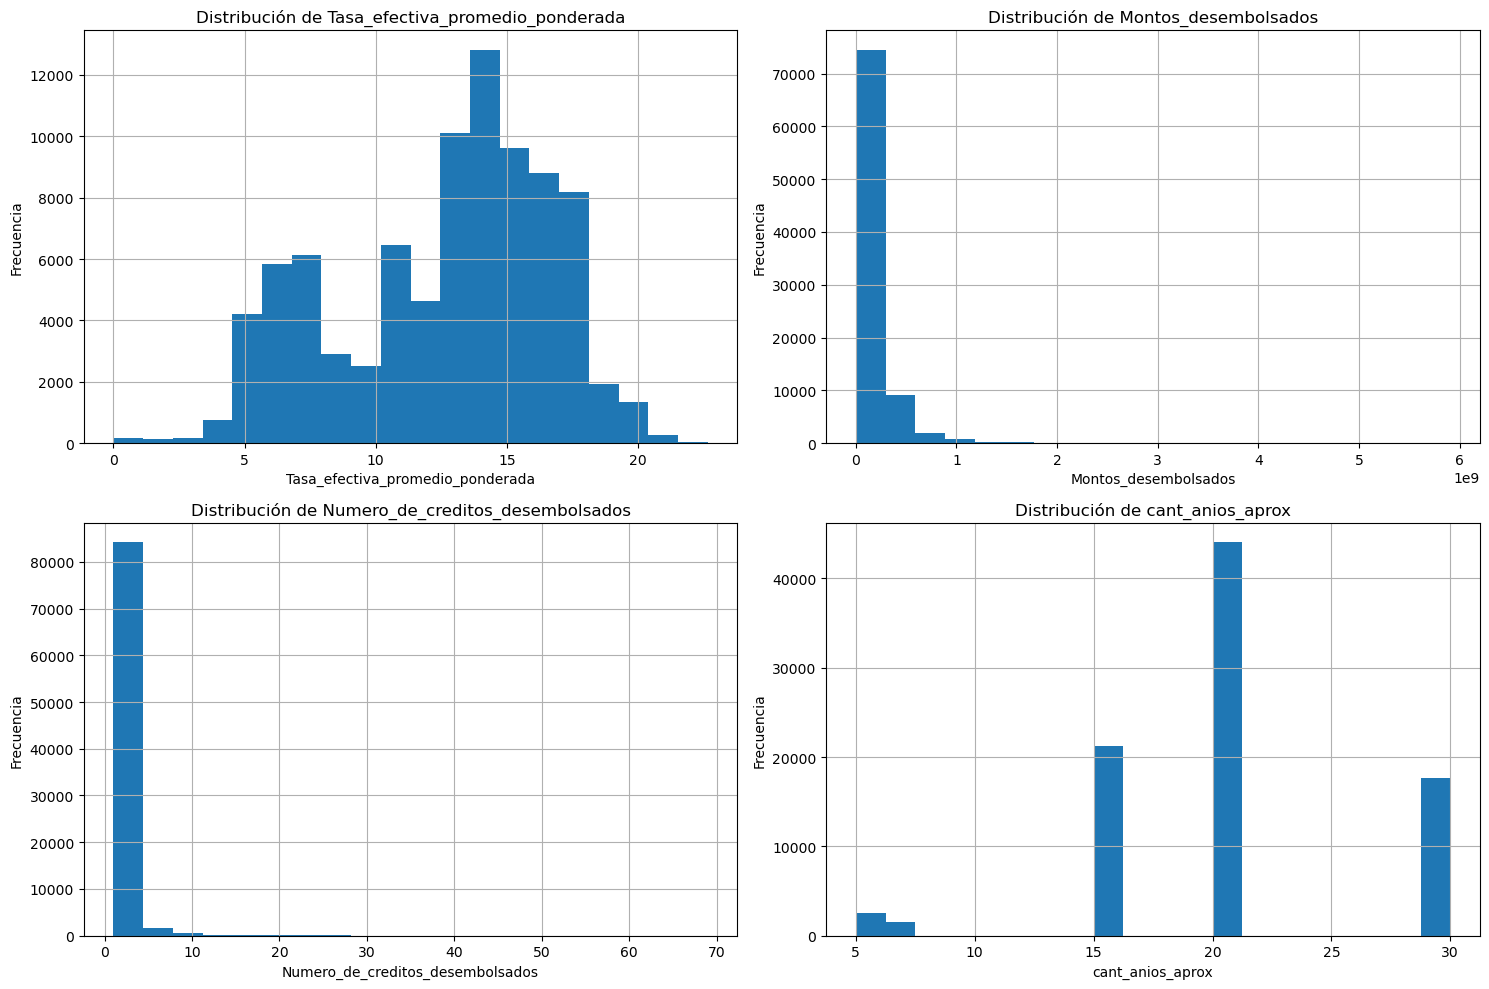

In [13]:
columnas_numericas = ['Tasa_efectiva_promedio_ponderada', 'Montos_desembolsados', 'Numero_de_creditos_desembolsados', 'cant_anios_aprox']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Iterar sobre las columnas y crear los histogramas
for i, columna in enumerate(columnas_numericas):
    row = i // 2
    col = i % 2
    
    # Crear un histograma
    df[columna].hist(ax=axes[row, col], bins=20)  # Ajusta el número de bins según tus datos
    axes[row, col].set_title(f'Distribución de {columna}')
    axes[row, col].set_xlabel(columna)
    axes[row, col].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

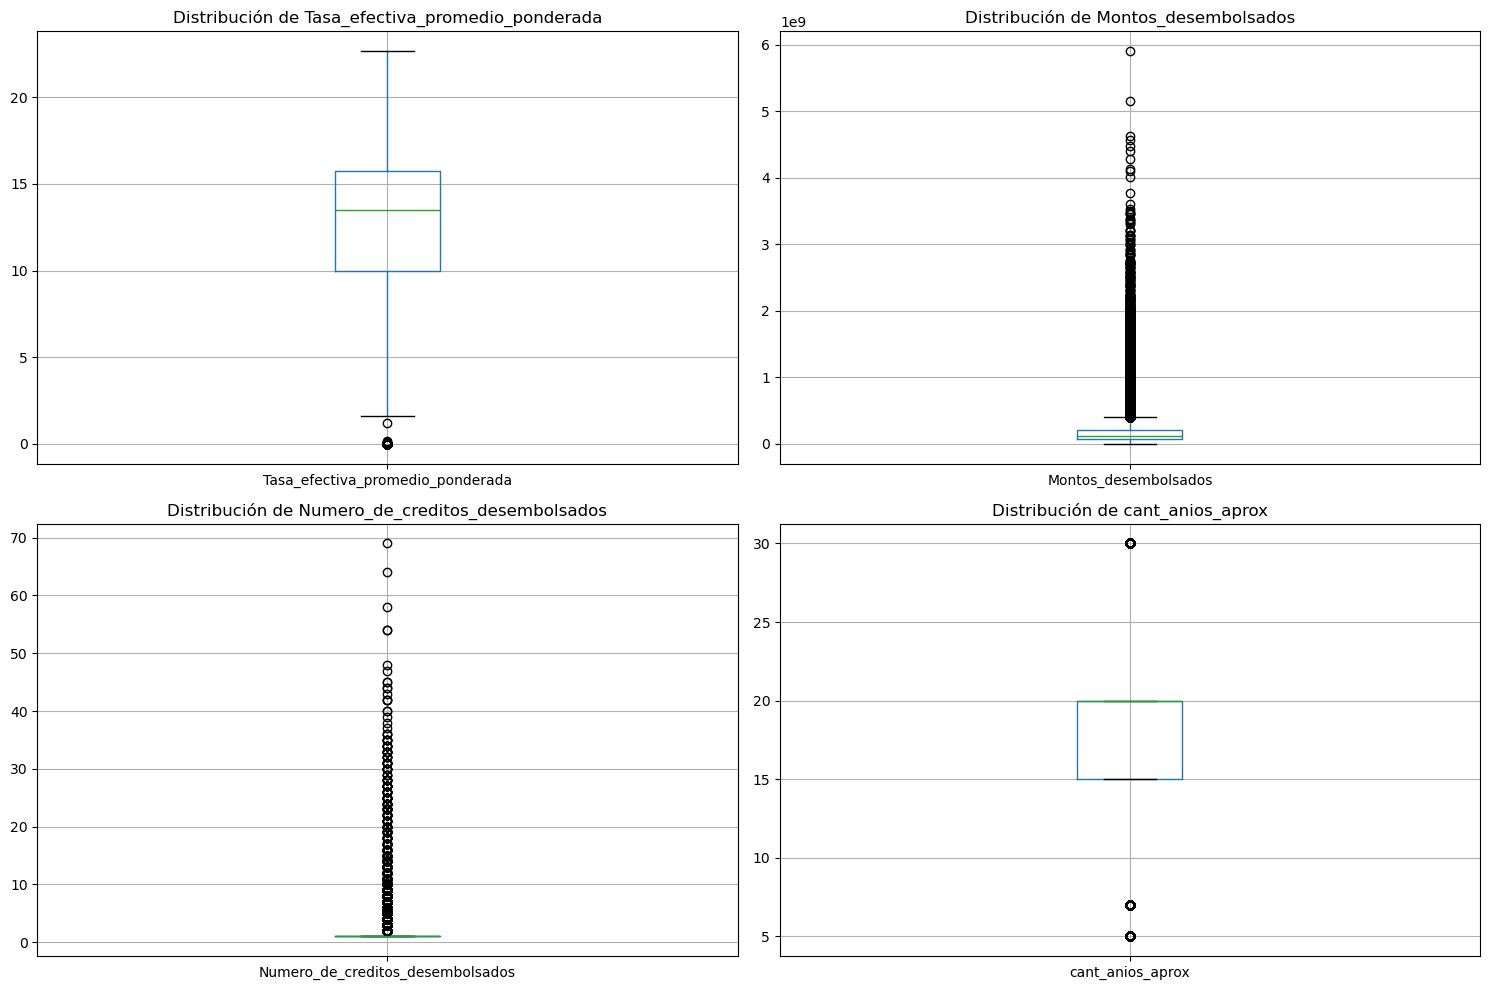

In [14]:
columnas_numericas = ['Tasa_efectiva_promedio_ponderada', 'Montos_desembolsados', 'Numero_de_creditos_desembolsados', 'cant_anios_aprox']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for i, columna in enumerate(columnas_numericas):
    row = i // 2
    col = i % 2
    
    df.boxplot(column=columna, ax=axes[row, col])
    axes[row, col].set_title(f'Distribución de {columna}')

plt.tight_layout()

plt.show()

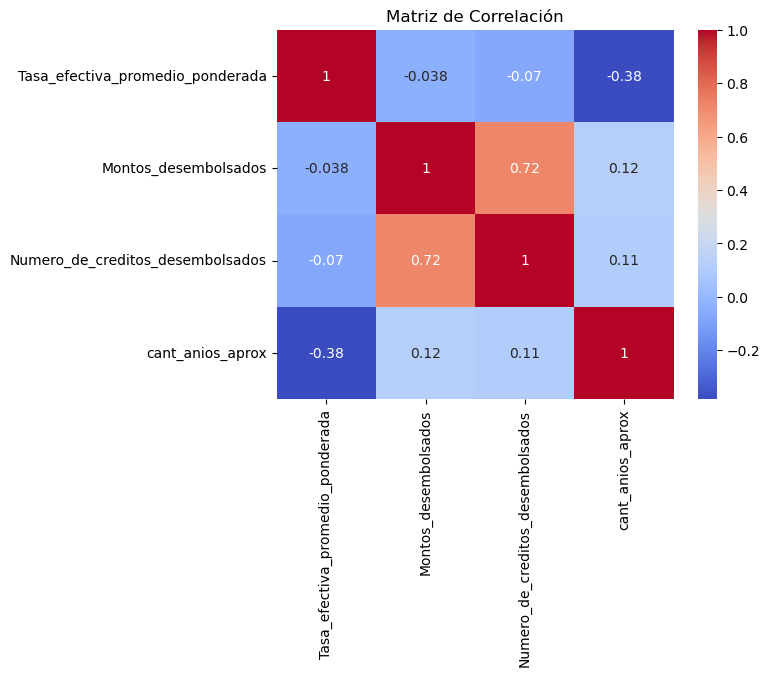

In [15]:
columnas_numericas = ['Tasa_efectiva_promedio_ponderada', 'Montos_desembolsados', 'Numero_de_creditos_desembolsados', 'cant_anios_aprox']
df_numerico = df[columnas_numericas]
matriz_correlacion = df_numerico.corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

<h4> Analisis variables categoricas: </h4>
<p> Nombre_Tipo_Entidad, Nombre_Entidad, Sexo, Producto de crédito, Plazo de crédito, Rango_monto_desembolsado, Clase_deudor.</p>

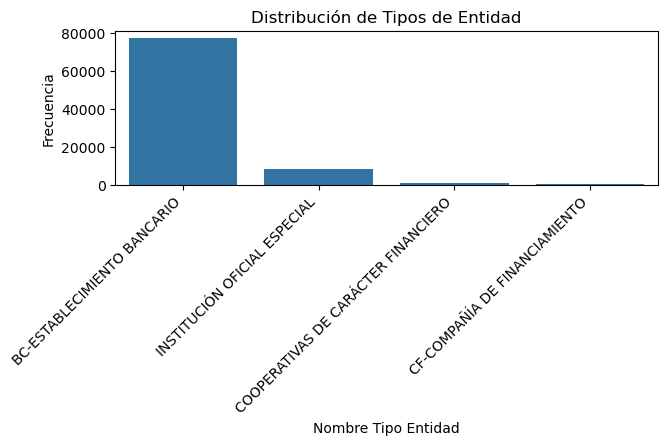

In [16]:
plt.figure(figsize=(7, 2))
sns.countplot(x='Nombre_Tipo_Entidad', data=df)

plt.title('Distribución de Tipos de Entidad')
plt.xlabel('Nombre Tipo Entidad')
plt.ylabel('Frecuencia')

plt.xticks(rotation=45, horizontalalignment='right')

plt.show()

In [17]:
# Cantidad de créditos desembolsados por entidad. 
conteo_entidades = df['Nombre_Entidad'].value_counts()
tabla_frecuencias = pd.DataFrame({'Nombre_Entidad': conteo_entidades.index, 'Cantidad de Créditos': conteo_entidades.values})
total_creditos = tabla_frecuencias['Cantidad de Créditos'].sum()
tabla_frecuencias['% de Créditos'] = (tabla_frecuencias['Cantidad de Créditos'] / total_creditos) * 100
tabla_frecuencias

,Nombre_Entidad,Cantidad de Créditos,% de Créditos
0,Banco Davivienda,20793,23.905770
1,Bancolombia,19130,21.993815
2,Banco de Bogotá,11129,12.795042
3,BBVA Colombia,9829,11.300429
4,Fondo Nacional del Ahorro,7834,9.006772
5,Banco Caja Social S.A.,5521,6.347509
6,Scotiabank Colpatria S.A.,3403,3.912439
7,AV Villas,2233,2.567286
8,Banco de Occidente,1747,2.008531
9,Banagrario,1333,1.532554


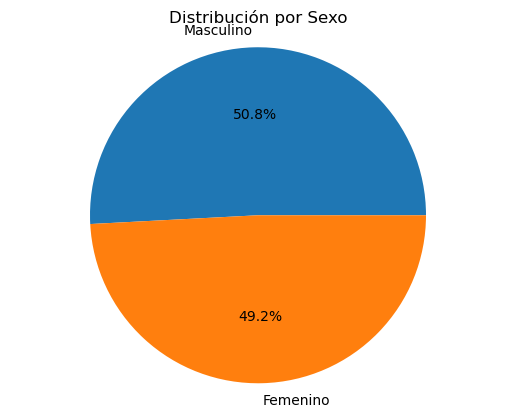

In [18]:
conteo_sexos = df['Sexo'].value_counts()

plt.pie(conteo_sexos, labels=conteo_sexos.index, autopct='%1.1f%%')
plt.title('Distribución por Sexo')
plt.axis('equal') 
plt.show()

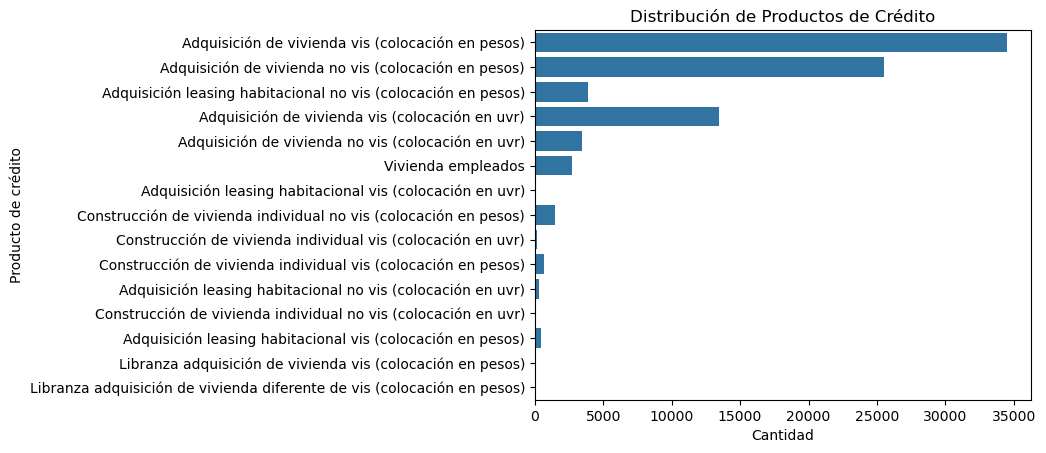

In [19]:
# Crear el gráfico de barras horizontales
sns.countplot(y='Producto de crédito', data=df)

plt.title('Distribución de Productos de Crédito')
plt.xlabel('Cantidad')
plt.ylabel('Producto de crédito')

plt.show()

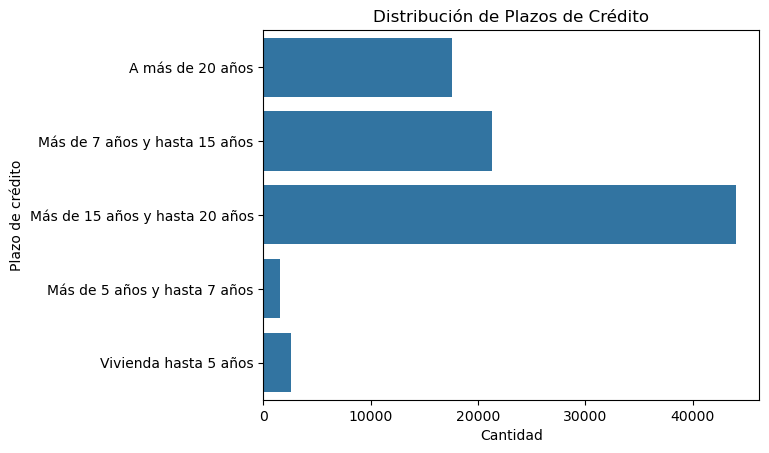

In [20]:
sns.countplot(y='Plazo de crédito', data=df)

plt.title('Distribución de Plazos de Crédito')
plt.xlabel('Cantidad')
plt.ylabel('Plazo de crédito')

plt.show()

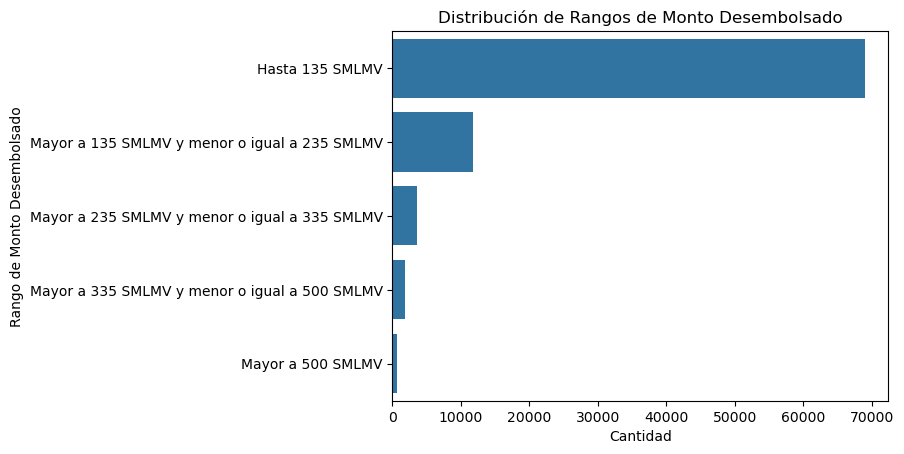

In [21]:
sns.countplot(y='Rango_monto_desembolsado', data=df)

plt.title('Distribución de Rangos de Monto Desembolsado')
plt.xlabel('Cantidad')
plt.ylabel('Rango de Monto Desembolsado')

plt.show()

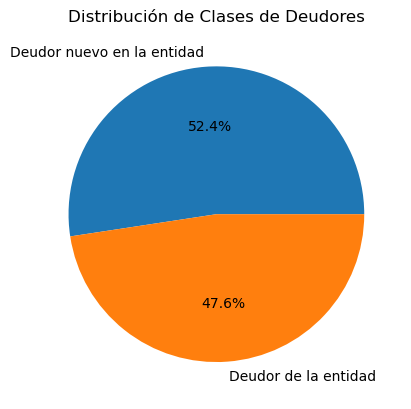

In [22]:
conteo_clases = df['Clase_deudor'].value_counts()
plt.pie(conteo_clases, labels=conteo_clases.index, autopct='%1.1f%%')

plt.title('Distribución de Clases de Deudores')

plt.show()

<h4> Analisis relaciones entre variables. </h4>

<p> 1. Analisis de la tasa de interes promedio por entidad financira.</p>

In [23]:
resultado = df.groupby('Nombre_Entidad')['Tasa_efectiva_promedio_ponderada'].mean().reset_index()
resultado.columns = ['Nombre_Entidad', 'Promedio_TE']
resultado = resultado.sort_values(by='Promedio_TE', ascending=False)
resultado['Promedio_TE'] = resultado['Promedio_TE'].round(2)
resultado

,Nombre_Entidad,Promedio_TE
16,Coofinep,19.42
25,Mibanco S.A.,19.12
8,Banco Unión,18.41
13,Bancoomeva,17.59
18,Cotrafa,16.09
4,Banco Caja Social S.A.,15.99
15,Confiar,14.76
23,Itaú,14.46
9,Banco de Bogotá,14.39
20,Financiera Juriscoop C.F.,14.07


<p> 2. Analisis de la tasa de interes promedio por plazo.</p>

In [24]:
tasa_prom_plazo = df.groupby('Plazo de crédito')['Tasa_efectiva_promedio_ponderada'].mean().reset_index()
tasa_prom_plazo.columns = ['Plazo', 'Promedio_TE']
tasa_prom_plazo = tasa_prom_plazo.sort_values(by='Promedio_TE', ascending=False)
tasa_prom_plazo['Promedio_TE'] = tasa_prom_plazo['Promedio_TE'].round(2)
tasa_prom_plazo

,Plazo,Promedio_TE
4,Vivienda hasta 5 años,15.32
2,Más de 5 años y hasta 7 años,14.98
3,Más de 7 años y hasta 15 años,14.12
1,Más de 15 años y hasta 20 años,12.75
0,A más de 20 años,9.75


                                  Tasa_efectiva_promedio_ponderada  \
Tasa_efectiva_promedio_ponderada                          1.000000   
Montos_desembolsados                                     -0.038083   

                                  Montos_desembolsados  
Tasa_efectiva_promedio_ponderada             -0.038083  
Montos_desembolsados                          1.000000  


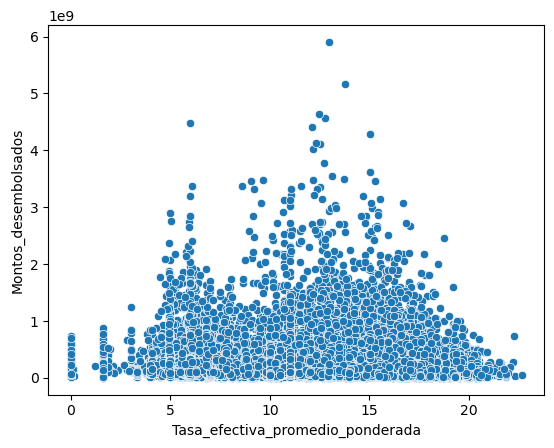

In [25]:
# Matriz de correlación
correlation_matrix = df[['Tasa_efectiva_promedio_ponderada', 'Montos_desembolsados']].corr()
print(correlation_matrix)

# Visualización: Diagrama de dispersión
sns.scatterplot(x='Tasa_efectiva_promedio_ponderada', y='Montos_desembolsados', data=df)
plt.show()

                                  Tasa_efectiva_promedio_ponderada  \
Tasa_efectiva_promedio_ponderada                          1.000000   
Numero_de_creditos_desembolsados                         -0.069505   

                                  Numero_de_creditos_desembolsados  
Tasa_efectiva_promedio_ponderada                         -0.069505  
Numero_de_creditos_desembolsados                          1.000000  


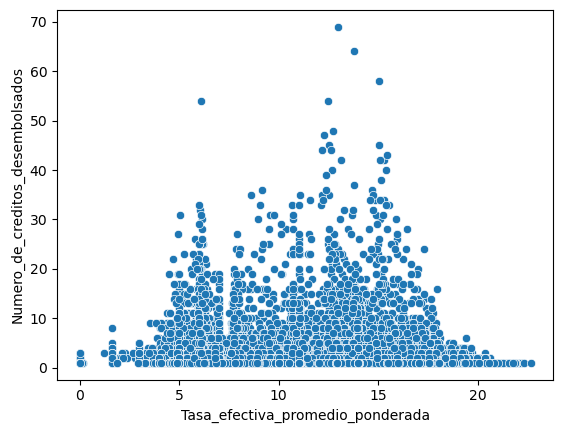

In [26]:
# Matriz de correlación
correlation_matrix = df[['Tasa_efectiva_promedio_ponderada', 'Numero_de_creditos_desembolsados']].corr()
print(correlation_matrix)

# Visualización: Diagrama de dispersión
sns.scatterplot(x='Tasa_efectiva_promedio_ponderada', y='Numero_de_creditos_desembolsados', data=df)
plt.show()

In [27]:
# Exportar el dataset procesado.
df.to_excel('datos_deudores.xlsx', index=False)